In [1]:
from pyspark import SparkContext # https://www.tutorialspoint.com/pyspark/pyspark_sparkcontext.htm
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from collections import namedtuple # https://www.geeksforgeeks.org/namedtuple-in-python/

import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

In [2]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [3]:
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)
socket_stream = ssc.socketTextStream("127.0.0.1", 5553)
lines = socket_stream.window( 20 )

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list # lambda is a function # (lambda arguments : expression)
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) #  Count and remove duplicates. #https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts them in Descending order in a DataFrame.
  .limit(10).registerTempTable("tweets") ) ) #Registers this DataFrame as a temporary table using the given name)

__________
### Before start next ssc.start() you should run TweetListener.py in the terminal
```
python TweetListener.py
```
__________

In [5]:
ssc.start()

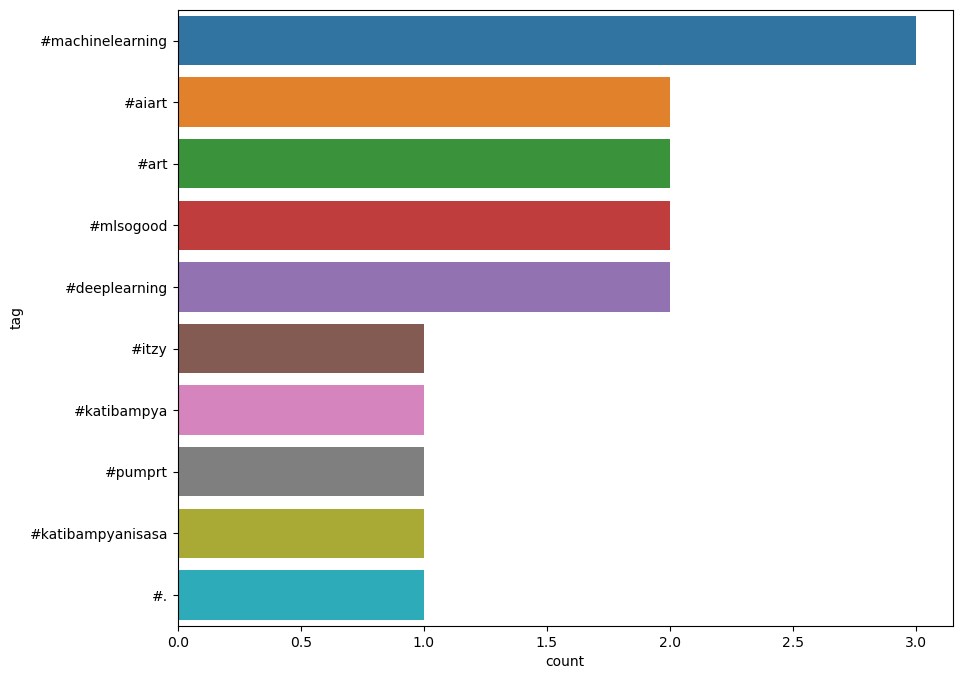

/usr/local/spark/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 44252)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/

In [7]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

In [13]:
ssc.stop()